In [1]:
import os
import glob
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('raw_omissions.pkl')

In [3]:
df['fbase'] = df.fname.apply(lambda x: os.path.basename(x).lower())

In [4]:
spcols = [f'nm{str(item)}' for item in range(400,510,10)]

In [5]:
df = df[[item for item in df.columns if 'nm' not in item]+spcols]

In [6]:
df[spcols] = df[spcols].applymap(float)

In [7]:
labcols = ['LAB_L','LAB_A','LAB_B']

In [8]:
df[labcols] = df[labcols].applymap(float)

In [9]:
df.mloc.value_counts()

dmin    40402
dmax    40049
dim         9
dmix        9
din         9
dmim        9
Name: mloc, dtype: int64

In [10]:
df.mloc[df.mloc.isin(['dmix','din','dmim','dim'])] = 'dmin'

# typos, etc.

In [11]:
df.catalog = df.catalog.apply(str)

In [12]:
def catalog_change(df,pre,post):
    df.catalog.loc[df.catalog==pre] = post

In [13]:
catalog_change(df,'2654','2645')
catalog_change(df,'4547','2547')
catalog_change(df,'5302r','5302q')
catalog_change(df,'5529r','5529q')
catalog_change(df,'5932','4932')
catalog_change(df,'2639','2639e')
catalog_change(df,'1649','1694')

In [14]:
def check_for_letters(s):
    for c in s:
        if not c.isdigit():
            return True

In [15]:
def sb_catalog_change(df,pre,post):
    tmp = df.loc[df.catalog.str.contains(pre)]
    tmp['has_letters'] = tmp.catalog.apply(check_for_letters)
    idxs = tmp.loc[tmp.has_letters==True].index
    
    for idx in idxs:
        catalog = df.catalog.loc[idx]
        suffix = ''.join([c for c in catalog if not c.isdigit()])
        df.catalog.loc[idx] = post + suffix

In [16]:
sb_catalog_change(df,'984','948')
sb_catalog_change(df,'310','301')
sb_catalog_change(df,'5156','5165')

In [17]:
df = df.loc[df.mmode.isin(['M0','M2'])]

In [18]:
df = df.reset_index(drop=True)

In [19]:
todrop = df.loc[(df.catalog=='5209ff')&(df.manbran=='gg')].index

In [20]:
df = df.drop(todrop)

In [21]:
df.catalog.loc[(df.catalog=='2372nn')&(df.manbran=='kt')] = '2372pp'

In [22]:
def binder_correction(df,catalog,binder,repl):
    df.catalog.loc[(df.catalog==catalog)&(df.fname.str.contains(binder))] = repl

In [23]:
binder_correction(df,'2569','binder1','2596')
binder_correction(df,'2240','binder6','2440')
binder_correction(df,'2173','binder5','2163')
binder_correction(df,'5046','binder7','5064')
binder_correction(df,'2355','binder4','2335')
binder_correction(df,'369','binder1','359')
binder_correction(df,'2883','binder7','2383')
binder_correction(df,'4945','binder7','5554')

## correcting mloc mislabels

#### dmin

<AxesSubplot:>

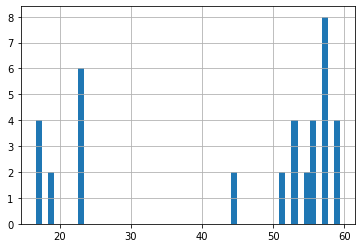

In [24]:
df.LAB_L.loc[(df.LAB_L < 60)&(df.mloc=='dmin')].hist(bins=50)

In [25]:
lowdmincats = df.catalog.loc[(df.LAB_L < 60)&(df.mloc=='dmin')].unique()

In [26]:
# for cat in lowdmincats:
#     tmp = df.loc[df.catalog==cat]
#     print(tmp[['catalog','LAB_L','mloc']],'\n\n\n\n')

In [27]:
df.mloc.loc[(df.catalog=='5493n')&(df.LAB_L < 30)] = 'dmax'

In [28]:
df.mloc.loc[(df.catalog=='5493n')&(df.LAB_L > 80)] = 'dmin'

In [29]:
df.mloc.loc[(df.catalog=='5486v')&(df.LAB_L < 30)] = 'dmax'

#### dmax

<AxesSubplot:>

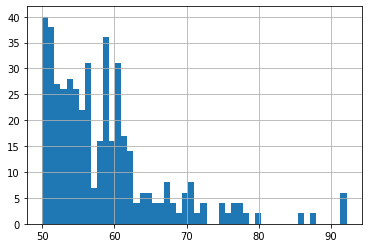

In [30]:
df.LAB_L.loc[(df.LAB_L > 50)&(df.mloc=='dmax')].hist(bins=50)

In [31]:
highdmaxcats = df.catalog.loc[(df.LAB_L > 40)&(df.mloc=='dmax')].unique()

In [32]:
for cat in highdmaxcats:
    tmp = df.loc[df.catalog==cat]
    
    if not all([loca in tmp.mloc.unique() for loca in ['dmax','dmin']]):
        print(cat)
    
    maxdmax = tmp.LAB_L.loc[tmp.mloc=='dmax'].max()
    mindmin = tmp.LAB_L.loc[tmp.mloc=='dmin'].min()
        
    if maxdmax >= mindmin:
        print(cat)

5532h


Ok just one error here: in 5532h, all measurements are labeled dmax, including some that must be dmins. In all other cases of high dmaxes, the dmins are even higher.

In [33]:
df.mloc.loc[(df.catalog=='5532h')&(df.LAB_L > 90)] = 'dmin'

In [34]:
df.mloc.value_counts()

dmin    26953
dmax    26693
Name: mloc, dtype: int64

#### no label vs sb dmins

So we are not quite done. It looks like there are more dmins than dmaxes. One issue here is that package samples were not labeled 'dmin', because there is no dmax. But I suspect there is another case of mislabeled measurements in here.

In [35]:
df['sample_type'] = None

In [36]:
f = "/Users/damoncrockett/lml2lux/notebooks/lml_w_copies.jsonl"

In [37]:
ff = pd.read_json(f, lines=True)

In [38]:
pkg = ff.loc[ff.Classification=='photographic paper package'].CatalogNumber

In [39]:
sb = ff.loc[ff.Classification=='photographic paper sample'].CatalogNumber

In [40]:
df.sample_type.loc[df.catalog.isin(sb)] = 'sample_book'
df.sample_type.loc[df.catalog.isin(pkg)] = 'package'

In [41]:
df.loc[df.sample_type.isnull()].fbase.unique()

array(['color_km_fomu.txt', 'color_km_binder1_1.txt',
       'color_km_binder3_2.txt', 'color_km_binder5_4.txt',
       'color_km_binder7_4.txt', 'color_km_binder3_1.txt',
       'color_km_binder7_5.txt', 'color_km_binder6_1.txt',
       'color_km_box3_2_5.txt', 'color_km_box3_2_4.txt'], dtype=object)

Sample book measurements where we left out mloc:

In [42]:
df.loc[(df.sample_type=='sample_book')&(df.mloc.isnull())]

,LAB_L,fname,LAB_A,LAB_B,rgbhex,mmode,ss,catalog,mtrial,mloc,...,nm420,nm430,nm440,nm450,nm460,nm470,nm480,nm490,nm500,sample_type


So here's what left of the binder papers with secondary catalog numbers (most were eliminated with the "omit from paperbase" flag, because they are color papers):

In [43]:
df.loc[(df.catalog.apply(check_for_letters)==True)&(df.sample_type=='package')].catalog.unique()

array(['1860a', '1860b', '1860c', '1860e', '1860g', '1860d'], dtype=object)

In [44]:
df.loc[(df.catalog.apply(check_for_letters)==True)&(df.sample_type=='package')].LAB_L.unique()

array([96.6 , 96.54, 96.63, 96.57, 96.32, 96.27, 94.67, 94.58, 94.7 ,
       94.62, 94.49, 94.41, 92.49, 92.34, 92.6 , 92.43, 91.83, 91.69,
       74.01, 73.93, 74.08, 73.99, 73.31, 73.23, 90.55, 90.51, 90.02,
       89.98, 90.6 , 90.56, 91.33, 91.18, 91.65, 91.51, 91.49])

Their LAB_L measurements look legit, so I will trust them (though I won't do anything just yet). And you might ask, but don't you know they are binder measurements because the filename says 'binder'? Yes, but that doesn't mean they are necessarily dmin measurements. There are a couple cases where the binder sample got exposed, and thus is actually dmax. But none of these seem like that.

Now, there are still three matters to attend to: first, we need to check the binder measurements to find potential exposures that create dmaxes. Then, we need to look at the sample book measurement to check whether there is parity between dmin and dmax in all cases. Finally, we need to look at cases where there is no sample_type (like the FOMU papers).

#### low binder measurements

In [45]:
df.sample_type.loc[df.mloc.isnull()].value_counts()

package    12476
Name: sample_type, dtype: int64

Ok so in every case of null mloc, the sample type is package. Good. We sort of knew that from above, by testing from the other direction.

In [46]:
df.mloc.loc[df.sample_type=='package'].value_counts()

dmin    240
dmax     12
Name: mloc, dtype: int64

In [47]:
df.sample_type.loc[(df.mloc=='dmax')&(df.sample_type=='package')] = "sample_book" # this mistake went to LUX

<AxesSubplot:>

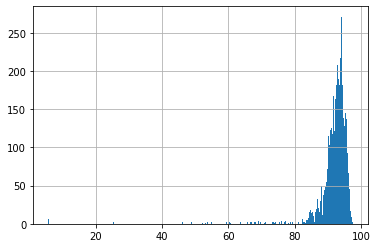

In [48]:
df.LAB_L.loc[df.sample_type=='package'].hist(bins=1000)

<AxesSubplot:>

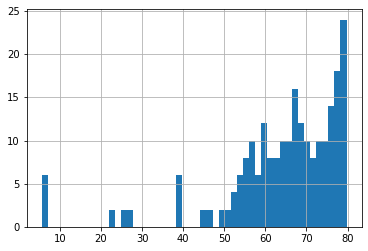

In [49]:
df.LAB_L[(df.sample_type=='package')&(df.LAB_L < 80)].hist(bins=50)

So, this is tough. There is no clear boundary here, and there are LOTS of samples with low LAB_L values. But these are all supposed to be dmin measurements. Clearly, some of these cannot be. Not sure how to handle this, except by checking the samples directly.

We could look to the sample book measurements as validation, since we KNOW when we have dmin:

<AxesSubplot:>

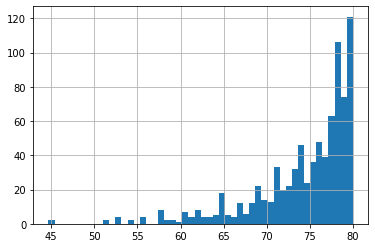

In [50]:
df.LAB_L[(df.sample_type=='sample_book')&(df.LAB_L < 80)&(df.mloc=='dmin')].hist(bins=50)

So there are certified dmin measurements as low as ~45, although that's an outlier, and above that is above 50. So maybe to be safe, we just check anything under 50.

In [51]:
df.LAB_L[(df.sample_type=='sample_book')&(df.LAB_L < 55)&(df.mloc=='dmin')].min()

44.66

<AxesSubplot:>

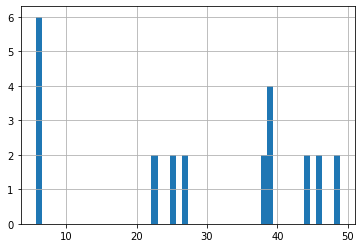

In [52]:
df.LAB_L[(df.sample_type=='package')&(df.LAB_L < 50)].hist(bins=50)

In [53]:
tmp = df.loc[(df.sample_type=='package')&(df.LAB_L < 50)].sort_values('fbase')

In [54]:
tmp[['catalog','fname','LAB_L']].groupby(['catalog','fname']).agg(np.median).sort_values('LAB_L').reset_index()

,catalog,fname,LAB_L
0,3122,/Users/damoncrockett/Dropbox/lml/genome_measur...,5.700
1,2523,/Users/damoncrockett/Dropbox/lml/genome_measur...,25.290
2,5191,/Users/damoncrockett/Dropbox/lml/genome_measur...,38.755
3,5166,/Users/damoncrockett/Dropbox/lml/genome_measur...,45.345
4,1786,/Users/damoncrockett/Dropbox/lml/genome_measur...,48.920


In [55]:
dropcats = tmp[['catalog','fname','LAB_L']].groupby(['catalog','fname']).agg(np.median).sort_values('LAB_L').reset_index().catalog

In [56]:
df = df.loc[~df.catalog.isin(dropcats)]

In [57]:
df = df.reset_index(drop=True)

Ok so we just dropped anything below LAB_L=50 in the binders. But probably we need a better approach. So here's an accounting:

0. 3122: jet black. This is Kodak Polycontrast Rapid II RC (1983)
1. 2576: Pigment paper, should be omitted from Paperbase
2. 2572: same
3. 2581: same
4. 2582: same
5. 2571: same
6. 2573: same
7. 2523: Illingworth Enitone from 1928. Looks very bad.
8. 183: Ektachrome (1979). Straight brown. Others like it, so probably just got missed in the omits.
9. 5191: Studio Proof (1964). Bad. Has reprint note.
10. 5166: Paget self-toning postcards from 1918. Bad.
11. 1786: Kodak Velvet Solio 1922. Bad.
12. 1424: Printon (1947) Straight burnt siena.

Ok none of these are legit. And leafing though the binders, I think there are lots of problematic cases, especially early. I think maybe the cutoff needs to be even higher, since the brightest of these is straight up brown.

#### sample book parity

In [58]:
sb = df.loc[df.sample_type=='sample_book']

In [59]:
sb.mloc.value_counts()

dmax    26675
dmin    26671
Name: mloc, dtype: int64

In [60]:
sb.loc[sb.catalog.isnull()]

,LAB_L,fname,LAB_A,LAB_B,rgbhex,mmode,ss,catalog,mtrial,mloc,...,nm420,nm430,nm440,nm450,nm460,nm470,nm480,nm490,nm500,sample_type


In [61]:
solocats = []
for cat in sb.catalog.unique():
    tmp = sb.loc[sb.catalog==cat]
    if set(tmp.mloc.unique())!={'dmax','dmin'}:
        print(cat,set(tmp.mloc.unique()))
        solocats.append(cat)

3194 {'dmax'}
1023l {'dmin'}
5513y {'dmin'}
5444a {'dmin'}
5464oo {'dmax'}
5514y {'dmin'}
5440 {'dmax'}


Ah interesting. So there are a bunch of cases with only one mloc.

In [62]:
# for cat in solocats:
#     tmp = sb.loc[sb.catalog==cat]
#     print(tmp[['catalog','mloc','LAB_L']],'\n\n\n\n')

Ok these look legit, but this imbalance works against the overall imbalance, so this can't explain it.

In [63]:
solos = []
for cat in sb.catalog.unique():
    tmp = sb.loc[sb.catalog==cat]
    if set(tmp.mloc.unique())=={'dmax','dmin'}:
        counts = tmp.mloc.value_counts()
        if len(set(counts))!=1:
            print(cat)
            solos.append(cat)

902t
294u
5528a
1023k
5486e
285b


In [64]:
df[['catalog',
    'LAB_L',
    'mloc',
    'mtrial',
    'mmode']].loc[(df.catalog.isin(solos))].sort_values(['catalog',
                                                         'mloc',
                                                         'mtrial',
                                                         'mmode',
                                                         'LAB_L']).to_csv('solos.csv')

Ok there are only two real issues here, where we don't have both M0 and M2 for a given trial. When this happens, we can't measure UV, so we will eliminate these cases:

In [65]:
idx = df.index[(df.catalog=='285b')&(df.mloc=='dmin')&(df.mmode=='M0')&(df.mtrial=='3')][0]

In [66]:
df = df.drop(idx)

In [67]:
idx = df.index[(df.catalog=='5486e')&(df.mloc=='dmax')&(df.mmode=='M0')&(df.mtrial=='1')][0]

In [68]:
df = df.drop(idx)

In [69]:
df = df.reset_index(drop=True)

#### no sample type

Ok these are all legit dmins, and they are all the FOMU papers. I do, however, have to get their catalog numbers right.

In [70]:
df.catalog.loc[(df.ss.str.contains('fomu_gb'))] = '5616'

In [71]:
df.catalog.loc[(df.ss.str.contains('fomu_gt'))] = '5617'

In [72]:
df.catalog.loc[(df.ss.str.contains('fomu_gg_'))] = '5618'

In [73]:
df.catalog.loc[(df.ss.str.contains('fomu_ggt'))] = '5619'

#### cleaning up

In [74]:
badcats = df.catalog.loc[df.additional.notnull()].unique()
badcats

array(['5150', '5149', '5151', '5155', '2293'], dtype=object)

In [75]:
okcats = ['5150','5155','2293']

In [76]:
badcats = list(set(badcats) - set(okcats))
badcats

['5151', '5149']

In [77]:
df = df.loc[~df.catalog.isin(badcats)]

In [78]:
todrop = df.loc[(df.catalog.str.contains('2088'))&(df.fname!='color_km_box1_1_1.txt')].index
todrop

Int64Index([ 1584,  1585,  1586,  1587,  1588,  1589,  1590,  1591,  1592,
             1593,
            ...
            62900, 62901, 62902, 62903, 62904, 62905, 62906, 62907, 62908,
            62909],
           dtype='int64', length=336)

In [79]:
df = df.drop(todrop)

In [80]:
df.mloc = df.mloc.fillna('dmin')

In [81]:
df = df.drop_duplicates(subset=['ss','LAB_L','LAB_A','LAB_B'])

In [82]:
df.manbran = df.manbran.fillna('::')

In [83]:
df.sample_type = df.sample_type.fillna('::')

In [84]:
df['cat'] = [f'{df.catalog.loc[i]}_{df.manbran.loc[i]}_{df.mloc.loc[i]}_{df.mtrial.loc[i]}_{df.mmode.loc[i]}' for i in df.index]

In [85]:
dupecats = df.cat.value_counts()[df.cat.value_counts()>1].index

In [86]:
def strip_letters(s):
    return ''.join([item for item in s if item.isdigit()])

In [87]:
dupecatalogs = set([strip_letters(item.split('_')[0]) for item in dupecats])

In [88]:
len(dupecatalogs)

46

In [89]:
df['catbase'] = df.catalog.apply(strip_letters)

In [90]:
misses = []
for d in dupecats:
    tmp = df.loc[df.cat==d]
    fnames = tmp.fname.unique()
    if all([any(['genome_2023' in item for item in fnames]),any(['genome_2021' in item for item in fnames])]):
        misses.append(d)

In [91]:
len(misses)

676

In [92]:
#f = "/Users/damoncrockett/Dropbox/lml/genome_measurements/genome_2023/_flags/Missed_Measurements_Master_List.xlsx"

In [93]:
#misscats = pd.read_excel(f)['Catalog #']

`dupecats` are any duplicates of `cat`, which is `catalog_manbran_mloc_mtrial_mmode`. Really, there should be no such duplicates (and really, trial dupes aren't genuinely duplicating anything; e.g., there is little chance the specific patch of paper was re-measured on that specific trial). But there are many of these --- across 47 catalog numbers, where a sample book has a single catalog number). If there are both old and new measurements, it is because we felt the item should be re-measured, so I will just try to find the mewest measurement and discard the rest (sometimes there are multiple 'old' measurements; sometimes even from 2023). `misses` are the cases where there are 2021 and 2023 measurements --- the easiest to consider, since we know they were re-measured for a reason. In these cases, we just take the newest measurements. When there are dupes but they all appear in either the 2021 or 2023 batches, we take a closer look, provided the diffs find a delta bigger than 5 units.

In [94]:
todrop = []
nondupes = []

for dupecat in dupecats:
    
    if dupecat in misses:
        tmp = df.loc[df.cat==dupecat]
        newest = tmp.loc[tmp.fname.str.contains('genome_2023')]
        
        if len(newest) > 1:
            newest = newest.loc[newest.fname.str.contains('_miss')]
            assert len(newest)==1
        
        newest_idx = newest.index[0]
        old_idxs = list(set(tmp.index) - set([newest_idx]))
        for old_idx in old_idxs:
            todrop.append(old_idx)
        continue
        
    tmp = df.loc[df.cat==dupecat]
    fbases = tmp.fbase.unique()
    if all([any(['_km_' in item for item in fbases]),any(['_sn_' in item for item in fbases])]):
        newest = tmp.loc[tmp.fbase.str.contains('_sn_')]
        assert len(newest)==1
        
        newest_idx = newest.index[0]
        old_idxs = list(set(tmp.index) - set([newest_idx]))
        for old_idx in old_idxs:
            todrop.append(old_idx)
        continue
        
    tmp = tmp[['cat']+labcols]
    if len(tmp) == 2:
        a = tmp.iloc[0,1:]
        b = tmp.iloc[1,1:]
        diff = list(a-b)
    elif len(tmp) == 3:
        a = tmp.iloc[0,1:]
        b = tmp.iloc[1,1:]
        c = tmp.iloc[2,1:]
        diff = list(a-b) + list(b-c)
    
    if any([abs(item) > 5 for item in diff]):
        nondupes.append(dupecat)

In [95]:
len(nondupes)

18

In [96]:
df = df.drop(todrop)

In [97]:
# import sys
# sys.path.append(os.path.expanduser("~"))
# from ss2csv.ss2csv import file2table,cleancols

In [98]:
# PRE = "/Users/damoncrockett/Dropbox/lml/genome_measurements/"

In [99]:
# tmp = cleancols(file2table(PRE+"genome_2023/color_sn_missing_05292024_1.txt")).SAMPLE_ID1
# set([item.strip('"').split('_')[0] for item in tmp])

In [100]:
#df[['LAB_L','mloc']].loc[df.catalog=='2078c']

In [101]:
for nondupe in sorted(nondupes):
    tmp = df[['fbase']+labcols][df.cat==nondupe]
    assert len(tmp)==2
    
    diff = abs(tmp.iloc[0,1:] - tmp.iloc[1,1:])
    
    if any([diff.LAB_A > 5, diff.LAB_B > 5]):
        print(nondupe,"\n",tmp,"\n\n")
        
    if diff.LAB_L > 10:
        print(nondupe,"\n",tmp,"\n\n")

2631j_ke_dmax_2_M0 
                     fbase  LAB_L  LAB_A  LAB_B
598  color_km_nobox_9.txt  20.82  -0.23   3.28
610  color_km_nobox_9.txt  31.10   0.11   7.95 


2631j_ke_dmax_2_M2 
                     fbase  LAB_L  LAB_A  LAB_B
599  color_km_nobox_9.txt  20.82  -0.24   3.30
611  color_km_nobox_9.txt  31.10   0.09   7.97 




These are fine.

## Inconsistent manbrans

These do occur. Worth looking at.

In [102]:
dropones = ['5150','5154']
pick_newers = ['5475a',
               '5475b',
               '5475c',
               '5475d',
               '5475e',
               '5475f',
               '5475g',
               '5475h',
               '5475i',
               '5475j',
               '5475k',
               '5475l',
               '5475m',
               '5475n',
               '5475o',
               '5475p',
               '5475q',
               '902a',
               '4790a',
               '5124',
               '5207v',
               '5207w',
               '5207x',
               '5493j',
               '5493k',
               '5493l',
               '5493m'
              ]
choose_manbrans = {
    "4793k":"kp",
    "2078i":"ip",
    "2078j":"ip",
    "2078n":"im",
    "2078o":"im",
    "2078p":"im",
    "2078q":"im",
    "2078r":"ic",
    "2078s":"ik",
    "2078t":"ik",
    "2092":"kb",
    "4885f":"de",
    "4885h":"dv",
    "4885j":"dv",
    "5493n":"ib",
    
}

In [103]:
for cat in sorted(df.catalog.unique()):
    tmp = df.loc[df.catalog==cat]
    manbrans = tmp.manbran.unique()
    if len(manbrans) > 1:
        if cat not in dropones and cat not in pick_newers and cat not in choose_manbrans.keys():
            tmp = tmp.drop_duplicates(['manbran','fbase'])
            print(cat,'\n',tmp[['manbran','fbase']],'\n\n')

In [104]:
todrop = []
for catalog in pick_newers:
    tmp = df.loc[df.catalog==catalog]
    fbases = tmp.fbase.unique()
    assert len(fbases)==2
    newer = tmp.loc[tmp.fbase.str.contains('_miss')]
    older = tmp.loc[tmp.fbase.str.contains('_km_')]
    if len(older)==0 or len(newer)==0:
        print(catalog)
    else:
        old_idxs = list(older.index)
        for oi in old_idxs:
            todrop.append(oi)

In [105]:
df = df.drop(todrop)

In [106]:
todrop = []
for catalog in choose_manbrans.keys():
    tmp = df.loc[df.catalog==catalog]
    manbrans = tmp.manbran.unique()
    assert len(manbrans)==2
    bad = tmp.loc[tmp.manbran!=choose_manbrans[catalog]]
    bad_idxs = list(bad.index)
    for bi in bad_idxs:
        todrop.append(bi)

In [107]:
df = df.drop(todrop)

In [108]:
len(df)

62364

In [109]:
len(df.drop_duplicates('cat'))

62038

In [110]:
df['catnomb'] = [f'{df.catalog.loc[i]}_{df.mloc.loc[i]}_{df.mtrial.loc[i]}_{df.mmode.loc[i]}' for i in df.index]

In [111]:
len(df.drop_duplicates('catnomb'))

62028

In [112]:
df = df.drop_duplicates('catnomb')

In [113]:
df = df.reset_index(drop=True)

In [114]:
df['catminus'] = ['_'.join(item.split('_')[:-1]) for item in df.cat]

In [115]:
solocats = df.catminus.value_counts()[df.catminus.value_counts()==1].index

In [116]:
solocats # only have a single mode

Index(['5511k_dn_dmax_0', '5495n_ai_dmax_0', '5533m_dn_dmax_1',
       '4885g_db_dmax_1', '3199h_kp_dmax_1', '2077f_ip_dmax_0',
       '5508f_ke_dmax_2', '4786p_gg_dmax_0'],
      dtype='object')

In [117]:
df = df.loc[~df.catminus.isin(solocats)]

In [118]:
df = df.reset_index(drop=True)

In [119]:
for catminus in df.catminus.unique():
    tmp = df.loc[df.catminus==catminus]
    assert len(tmp)==2
    assert set(tmp.mmode.unique())=={'M0','M2'}

In [120]:
df.to_pickle('raw_omissions_corrections.pkl')